In [1]:
!pip install datasets
!pip install optuna
!pip install scikit-multilearn
!pip install PyEvALL

import pandas as pd
import logging
from datasets import Dataset
import os
import optuna
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer, AutoModel
from transformers import set_seed
import random

# Import the drive library
from google.colab import drive
drive.mount('/content/drive/')
import sys
sys.path.append('drive/MyDrive/Colab/thesis/models')
from utils_classification import *

Mounted at /content/drive/


In [2]:
seed = 0
set_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [3]:
dir = "/content/drive/MyDrive/Colab/thesis"

In [4]:
class DataLoader:
    def __init__(self, tokenizer, device='cpu', max_length=512):
        """
        Initialize the data loader.

        Parameters:
        - tokenizer: Hugging Face tokenizer.
        - device (str): Device to load the tensors onto.
        - max_length (int): Max sequence length for padding/truncation.
        """
        self.tokenizer = tokenizer
        self.device = device
        self.max_length = max_length

    def tokenize(self, texts):
        """
        Tokenize a list of text samples.

        Parameters:
        - texts (list): List of strings.

        Return:
        - dict: Tokenized inputs as tensors on the specified device.
        """
        tokenized = self.tokenizer(
            texts,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        ).to(self.device)

        return tokenized

    def load(self, data, labels=None):
        """
        Load and return a Hugging Face Dataset object.

        Parameters:
        - data (list): List of input texts.
        - labels (list, optional): Labels corresponding to the input texts.

        Return:
        - Dataset: Hugging Face Dataset object with tokenized inputs.
        """
        tokenized = self.tokenize(data)

        if labels is not None:
            tokenized = {**tokenized, 'labels': torch.tensor(labels).to(self.device)}

        dataset_dict = {k: v.cpu() for k, v in tokenized.items()}
        hf_dataset = Dataset.from_dict(dataset_dict)

        return hf_dataset

# EXIST 2024

In [5]:
ds_name = "EXIST2024"
exist_training_data = "".join([dir, "/data/EXIST2024/EXIST2024_training.json"])
exist_val_data = "".join([dir,"/data/EXIST2024/EXIST2024_validation.json"])
exist_test_data = "".join([dir, "/data/EXIST2024/EXIST2024_test.json"])

In [6]:
exist_train_df = pd.read_json(exist_training_data,orient='index')
exist_dev_df = pd.read_json(exist_val_data,orient='index')
exist_test_df = pd.read_json(exist_test_data,orient='index')

## Binary Classification: Sexist vs. non-sexist

In [7]:
evaluation_type = "binary"
#division and processing of data as input to the model
X_train = exist_train_df["bert representation"].tolist()
y_train = exist_train_df["sexist"].tolist()
X_dev = exist_dev_df["bert representation"].tolist()
y_dev = exist_dev_df["sexist"].tolist()
X_test = exist_test_df["bert representation"].tolist()
y_test = exist_test_df["sexist"].tolist()

In [ ]:
#load bert model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained('NLP-LTU/bertweet-large-sexism-detector')
tokenizer = AutoTokenizer.from_pretrained('NLP-LTU/bertweet-large-sexism-detector')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=Tru

In [ ]:
#tokenize data and format as dataset dict for fine-tuning
data_loader = DataLoader(tokenizer, device=device)
train_data = data_loader.load(X_train, y_train)
dev_data = data_loader.load(X_dev, y_dev)

In [ ]:
task = "sexism-identification"
model_name = "bertweet-large"
SAVE_DIR = dir + f"/models/in_domain/{ds_name}/{evaluation_type}/bertweet-large-sexism-detector/{model_name}-{task}"

print('Training the model on the custom parameters')

args = TrainingArguments(
        output_dir=SAVE_DIR,
        eval_strategy="epoch",
        #learning_rate=best_lr,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        num_train_epochs=4,
        #weight_decay=best_weight_decay,
        report_to="none",
        save_strategy="no",
        metric_for_best_model="eval_f1"
    )

trainer = Trainer(
        model,
        args,
        train_dataset=train_data,
        eval_dataset=dev_data,
        processing_class=tokenizer,
        compute_metrics=compute_metrics
    )
result = trainer.train()

Training the model on the custom parameters


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.702095,0.744118,0.741610,0.738283
2,No log,0.803301,0.744599,0.744264,0.744399
3,No log,1.011658,0.759927,0.755565,0.756128
4,No log,1.148615,0.752690,0.749315,0.749828


In [ ]:
trainer.evaluate()

{'eval_loss': 1.1486146450042725,
 'eval_precision': 0.7526900381811871,
 'eval_recall': 0.7493150684931507,
 'eval_f1': 0.749827882960413,
 'eval_runtime': 2.9698,
 'eval_samples_per_second': 51.518,
 'eval_steps_per_second': 1.684,
 'epoch': 4.0}

In [ ]:
model_dir = dir + f"/models/in_domain/{ds_name}/{evaluation_type}/bertweet-large-sexism-detector/{model_name}-{task}"
tokenizer.save_pretrained(model_dir+"/tokenizer")
model.save_pretrained(model_dir+"/model")

In [ ]:
# testing fine-tuned model for sexism identification

In [8]:
#loading fine-tuned model and tokenizer
evaluation_type = "binary"
task = "sexism-identification"
model_name = "bertweet-large"
model_dir = dir + f"/models/in_domain/{ds_name}/{evaluation_type}/bertweet-large-sexism-detector/{model_name}-{task}"
sexism_id_model = AutoModelForSequenceClassification.from_pretrained(model_dir+"/model")
sexism_id_tokenizer = AutoTokenizer.from_pretrained(model_dir+"/tokenizer")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sexism_id_model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=Tru

In [9]:
#make predictions on dev data
y_pred = exist_dev_df["bert representation"].apply(lambda x: classify_text(x, sexism_id_model, sexism_id_tokenizer, device))

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Saved EXIST2024 validation split binary evaluation to /content/drive/MyDrive/Colab/thesis/models/evaluation/predictions/EXIST2024/bertweet-large-sexism-detector_EXIST2024_validation_binary.json
Saved EXIST2024 validation split to /content/drive/MyDrive/Colab/thesis/models/evaluation/predictions/EXIST2024/bertweet-large-sexism-detector_EXIST2024_validation_answer.txt
----------------------------------------------------------------------------------------------------
Classification Report for bertweet-large-sexism-detector:
              precision    recall  f1-score   support

  non-sexist       0.76      0.70      0.73        73
      sexist       0.74      0.80      0.77        80

    accuracy                           0.75       153
   macro avg       0.75      0.75      0.75       153
weighted avg       0.75      0.75      0.75       153

----------------------------------------------------------------------------------------------------
--------------------------------------------

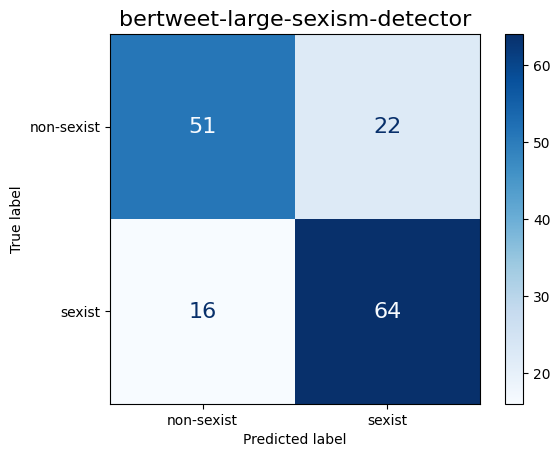

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
PyEvaLL Metrics for bertweet-large-sexism-detector:

2025-07-15 08:22:29,619 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['ICM', 'ICMNorm', 'FMeasure']
2025-07-15 08:22:30,406 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-07-15 08:22:30,462 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM Normalized evaluation method
2025-07-15 08:22:30,464 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-07-15 08:22:30,538 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-07-15 08:22:30,589 - pyevall.metrics.metrics - INFO -             evaluate() - Executing fmeasure evaluation method
cargad

In [10]:
gold_path_dev_binary =  dir+f"/models/evaluation/golds/{ds_name}/{ds_name}_validation_{evaluation_type}.json"
gold_dev_txt = dir+f"/models/evaluation/golds/{ds_name}/{ds_name}_validation_truth.txt"
#create file with predictions
dev_pred_json,dev_pred_txt = save_evaluation(exist_dev_df, dir+"/models/evaluation/predictions", ds_name, "validation", evaluation_type, "bertweet-large-sexism-detector", y_pred, "sexist", [])
#get evaluation metrics
evaluate_binary_classification(gold_path_dev_binary,dev_pred_json,
                               y_dev,y_pred,
                                ["non-sexist","sexist"],
                               gold_dev_txt,dev_pred_txt,
                               model_name="bertweet-large-sexism-detector")

In [ ]:
#make predictions on test data
y_pred = exist_test_df["bert representation"].apply(lambda x: classify_text(x, sexism_id_model, sexism_id_tokenizer, device))

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Saved EXIST2024 test split binary evaluation to /content/drive/MyDrive/Colab/thesis/models/evaluation/predictions/EXIST2024/bertweet-large-sexism-detector_EXIST2024_test_binary.json
Saved EXIST2024 test split to /content/drive/MyDrive/Colab/thesis/models/evaluation/predictions/EXIST2024/bertweet-large-sexism-detector_EXIST2024_test_answer.txt
----------------------------------------------------------------------------------------------------
Classification Report for bertweet-large-sexism-detector:
              precision    recall  f1-score   support

  non-sexist       0.66      0.67      0.67        76
      sexist       0.73      0.73      0.73        95

    accuracy                           0.70       171
   macro avg       0.70      0.70      0.70       171
weighted avg       0.70      0.70      0.70       171

----------------------------------------------------------------------------------------------------
--------------------------------------------------------------------

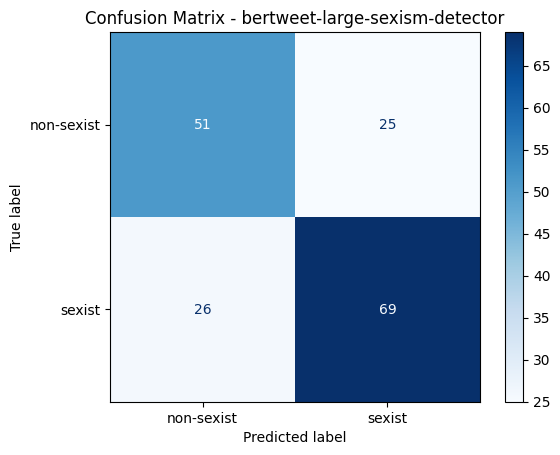

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
PyEvaLL Metrics for bertweet-large-sexism-detector:

2025-05-11 21:56:06,962 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['ICM', 'ICMNorm', 'FMeasure']
2025-05-11 21:56:09,848 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-05-11 21:56:09,909 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM Normalized evaluation method
2025-05-11 21:56:09,911 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-05-11 21:56:09,968 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-05-11 21:56:10,028 - pyevall.metrics.metrics - INFO -             evaluate() - Executing fmeasure evaluation method
cargad

In [ ]:
gold_path_test_binary =  dir+f"/models/evaluation/golds/{ds_name}/{ds_name}_test_{evaluation_type}.json"
gold_test_txt = dir+f"/models/evaluation/golds/{ds_name}/{ds_name}_test_truth.txt"
#create file with predictions
test_pred_json,test_pred_txt = save_evaluation(exist_test_df, dir+"/models/evaluation/predictions", ds_name, "test", evaluation_type, "bertweet-large-sexism-detector", y_pred, "sexist", [])
#get evaluation metrics
evaluate_binary_classification(gold_path_test_binary,test_pred_json,
                               y_test,y_pred,
                                ["non-sexist","sexist"],
                               gold_test_txt,test_pred_txt,
                               model_name="bertweet-large-sexism-detector")

In [ ]:
#save predictions on test set
output_dir = os.path.join(dir, "models","output",ds_name) #creating dir for output
os.makedirs(output_dir, exist_ok=True)
output_path = f"{output_dir}/bertweet-large-sexism-detector_{ds_name}_test_{evaluation_type}.csv"
save_predictions_csv(exist_test_df, y_pred.to_numpy(), ["sexist"], output_path)

Predictions saved to /content/drive/MyDrive/Colab/thesis/models/output/EXIST2024/bertweet-large-sexism-detector_EXIST2024_test_binary.csv
